In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

In [2]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

In [3]:
train_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True) 
test_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True)

In [4]:
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

In [5]:
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

In [6]:
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 1 else 1)
test_df['label'] = -1

In [18]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stopwords = TfidfVectorizer(stop_words='english').get_stop_words()
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

# Define the text and relevant variables column transformer with SelectKBest
text_and_vars_transformer = ColumnTransformer([
    ('text', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'reviewText'),
    ('summary', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'summary'),
    ('verified', OneHotEncoder(), ['verified']), # Encode the 'verified' column
    ('vote', 'passthrough', ['vote'])
])

# Split the training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Concatenate the text data with other relevant variables
train_features = text_and_vars_transformer.fit_transform(train_df[['reviewText', 'summary', 'verified', 'vote']])
valid_features = text_and_vars_transformer.transform(valid_df[['reviewText', 'summary', 'verified', 'vote']])
test_features = text_and_vars_transformer.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label = train_df['label']
valid_label = valid_df['label']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average F1 Score: 0.7050750792470282  Standard Deviation: 0.016091379453293753  for {'C': 1}
Average F1 Score: 0.7396169103773961  Standard Deviation: 0.01727450739296127  for {'C': 10}
Average F1 Score: 0.7447633668712138  Standard Deviation: 0.016336190363996552  for {'C': 50}
Average F1 Score: 0.7477511021829032  Standard Deviation: 0.016856066787957966  for {'C': 100}

Logistic Regression Classifier:
Optimal Hyperparameters: {'C': 100}
Maximum F1 Score: 0.7477511021829032

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.72      0.53      0.61       928
           1       0.89      0.95      0.92      3743

    accuracy                           0.87      4671
   macro avg       0.81      0.74      0.76      4671
weighted avg       0.86      0.87      0.86      4671

Confusion Matrix:
 [[ 490  438]
 [ 190 3553]]
Accuracy: 0.8655534146863627
AUC Score: 0.8898789234156632
Macro F1 Score: 0.7641264198788833


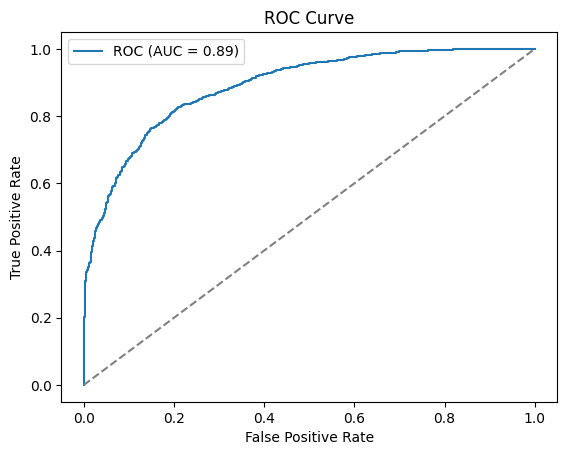

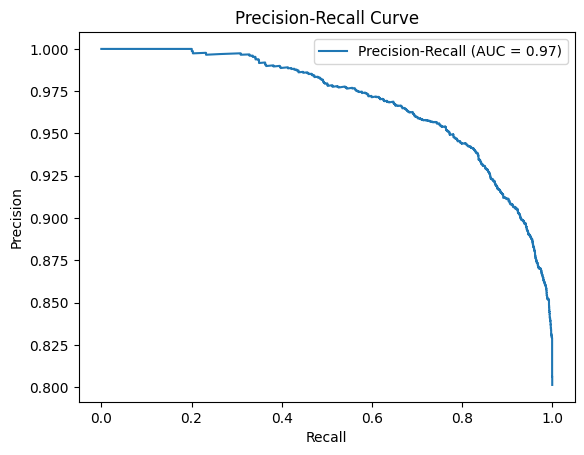

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Logistic Regression Classifier initialization
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Hyperparameters for Logistic Regression
lr_hyperparameters = {'C': [1, 10, 50, 100]}

# Grid search with 5-fold cross-validation
lr_cv_grid = GridSearchCV(log_reg, lr_hyperparameters, cv=5, scoring='f1_macro')
lr_cv_grid.fit(train_features, train_label)

# Cross-validation results
cv_outcomes = lr_cv_grid.cv_results_
for avg_f1, std_f1, hyperparam in zip(cv_outcomes['mean_test_score'], cv_outcomes['std_test_score'], cv_outcomes['params']):
    print("Average F1 Score:", avg_f1, " Standard Deviation:", std_f1, " for", hyperparam)

# Best parameters and score
print('\nLogistic Regression Classifier:')
print('Optimal Hyperparameters:', lr_cv_grid.best_params_)
print('Maximum F1 Score:', lr_cv_grid.best_score_)

# Model evaluation
optimal_lr = lr_cv_grid.best_estimator_
valid_prediction = optimal_lr.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_prediction))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_prediction))
print('Accuracy:', accuracy_score(valid_label, valid_prediction))
print('AUC Score:', roc_auc_score(valid_label, optimal_lr.predict_proba(valid_features)[:,1]))
print('Macro F1 Score:', f1_score(valid_label, valid_prediction, average='macro'))

# ROC curve
fpr, tpr, _ = roc_curve(valid_label, optimal_lr.predict_proba(valid_features)[:,1])
roc_auc_val = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(valid_label, optimal_lr.predict_proba(valid_features)[:,1])
prc_auc_val = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall (AUC = {prc_auc_val:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Predict on test set and save to csv
test_prediction = optimal_lr.predict(test_features)
test_df['prediction'] = test_prediction
result_df = pd.DataFrame({'id': test_df.index, 'prediction': test_df['prediction']})
result_df.to_csv('LR_Result_Submission.csv', index=False)


Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 1}
Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 5}
Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 10}
Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 20}
Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 50}
Average F1 Score: 0.5821545655392492  Standard Deviation: 0.009296791347761083  for {'max_depth': 2, 'min_samples_leaf': 100}
Average F1 Score: 0.6427320305802925  Standard Deviation: 0.00985729091429669  for {'max_depth': 5, 'min_samples_leaf': 1}
Average F1 Score: 0.641126675392803  Standard Deviation: 0.008423804365013703  for {'max_depth': 5, 'min_samples_leaf': 5}
Avera

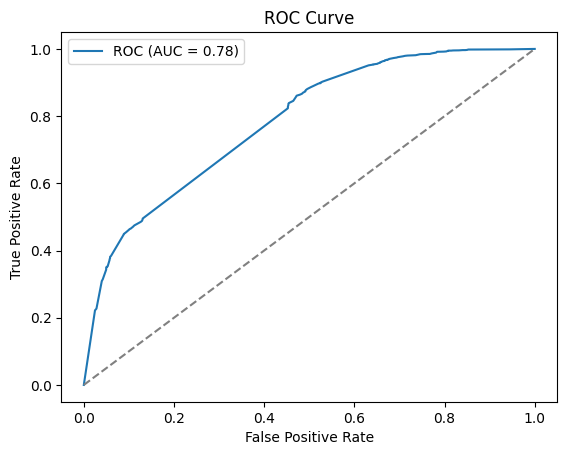

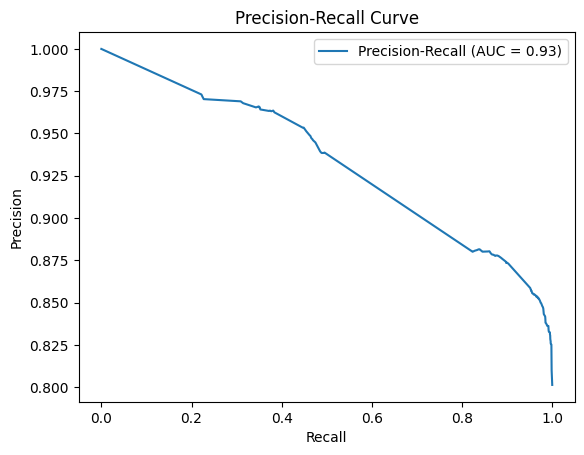

In [26]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV

# Decision Tree Classifier initialization
tree_clf = DecisionTreeClassifier(random_state=42)

# Hyperparameters for Decision Tree
tree_hyperparameters = {'max_depth': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 20, 50, 100]}

# Grid search with 5-fold cross-validation
tree_cv_grid = GridSearchCV(tree_clf, tree_hyperparameters, cv=5, scoring='f1_macro')
tree_cv_grid.fit(train_features, train_label)

# Cross-validation results
cv_outcomes_tree = tree_cv_grid.cv_results_
for avg_f1, std_f1, hyperparam in zip(cv_outcomes_tree['mean_test_score'], cv_outcomes_tree['std_test_score'], cv_outcomes_tree['params']):
    print("Average F1 Score:", avg_f1, " Standard Deviation:", std_f1, " for", hyperparam)

# Best parameters and score
print('\nDecision Tree Classifier:')
print('Optimal Hyperparameters:', tree_cv_grid.best_params_)
print('Maximum F1 Score:', tree_cv_grid.best_score_)

# Model evaluation
optimal_tree = tree_cv_grid.best_estimator_
valid_prediction_tree = optimal_tree.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_prediction_tree))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_prediction_tree))
print('Accuracy:', accuracy_score(valid_label, valid_prediction_tree))
print('AUC Score:', roc_auc_score(valid_label, optimal_tree.predict_proba(valid_features)[:,1]))

# ROC curve
fpr_tree, tpr_tree, _ = roc_curve(valid_label, optimal_tree.predict_proba(valid_features)[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, label=f'ROC (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision_tree, recall_tree, _ = precision_recall_curve(valid_label, optimal_tree.predict_proba(valid_features)[:,1])
prc_auc_tree = auc(recall_tree, precision_tree)
plt.figure()
plt.plot(recall_tree, precision_tree, label=f'Precision-Recall (AUC = {prc_auc_tree:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Predict on test set and save to csv
test_prediction_tree = optimal_tree.predict(test_features)
test_df['prediction'] = test_prediction_tree
result_df_tree = pd.DataFrame({'id': test_df.index, 'prediction': test_df['prediction']})
result_df_tree.to_csv('DecisionTree_Result_Submission.csv', index=False)


Average F1 Score: 0.6730006528579182  Standard Deviation: 0.0036191397675814363  for {'alpha': 0.001}
Average F1 Score: 0.7189680998909047  Standard Deviation: 0.005672890333429551  for {'alpha': 0.1}
Average F1 Score: 0.5836385704001745  Standard Deviation: 0.007711176156088892  for {'alpha': 0.5}
Average F1 Score: 0.5768741328469486  Standard Deviation: 0.006857205865605825  for {'alpha': 1.0}
Average F1 Score: 0.574115694488599  Standard Deviation: 0.007079479809689108  for {'alpha': 2.0}

Multinomial Naive Bayes Classifier:
Optimal Hyperparameters: {'alpha': 0.1}
Maximum F1 Score: 0.7189680998909047

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.92      0.24      0.39       928
           1       0.84      0.99      0.91      3743

    accuracy                           0.85      4671
   macro avg       0.88      0.62      0.65      4671
weighted avg       0.86      0.85      0.81      4671

Confusion Matrix:
 [

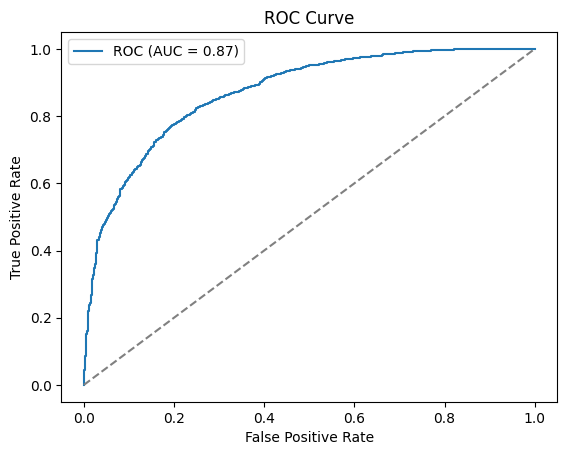

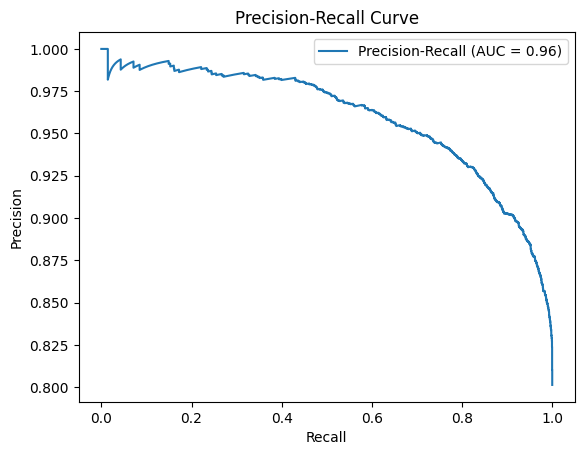

In [27]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV

# Multinomial Naive Bayes Classifier setup
bayes_clf = MultinomialNB()

# Hyperparameters for Naive Bayes
bayes_hyperparameters = {'alpha': [0.001, 0.1, 0.5, 1.0, 2.0]}

# Grid search with 5-fold cross-validation
bayes_cv_grid = GridSearchCV(bayes_clf, bayes_hyperparameters, cv=5, scoring='f1_macro')
bayes_cv_grid.fit(train_features, train_label)

# Cross-validation results
cv_outcomes_bayes = bayes_cv_grid.cv_results_
for avg_f1, std_f1, hyperparam in zip(cv_outcomes_bayes['mean_test_score'], cv_outcomes_bayes['std_test_score'], cv_outcomes_bayes['params']):
    print("Average F1 Score:", avg_f1, " Standard Deviation:", std_f1, " for", hyperparam)

# Best parameters and score
print('\nMultinomial Naive Bayes Classifier:')
print('Optimal Hyperparameters:', bayes_cv_grid.best_params_)
print('Maximum F1 Score:', bayes_cv_grid.best_score_)

# Model evaluation
optimal_bayes = bayes_cv_grid.best_estimator_
valid_prediction_bayes = optimal_bayes.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_prediction_bayes))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_prediction_bayes))
print('Accuracy:', accuracy_score(valid_label, valid_prediction_bayes))
print('AUC Score:', roc_auc_score(valid_label, optimal_bayes.predict_proba(valid_features)[:,1]))

# ROC curve
fpr_bayes, tpr_bayes, _ = roc_curve(valid_label, optimal_bayes.predict_proba(valid_features)[:,1])
roc_auc_bayes = auc(fpr_bayes, tpr_bayes)
plt.figure()
plt.plot(fpr_bayes, tpr_bayes, label=f'ROC (AUC = {roc_auc_bayes:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision_bayes, recall_bayes, _ = precision_recall_curve(valid_label, optimal_bayes.predict_proba(valid_features)[:,1])
prc_auc_bayes = auc(recall_bayes, precision_bayes)
plt.figure()
plt.plot(recall_bayes, precision_bayes, label=f'Precision-Recall (AUC = {prc_auc_bayes:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Predict on test set and save to csv
test_prediction_bayes = optimal_bayes.predict(test_features)
test_df['prediction'] = test_prediction_bayes
result_df_bayes = pd.DataFrame({'id': test_df.index, 'prediction': test_df['prediction']})
result_df_bayes.to_csv('NaiveBayes_Result_Submission.csv', index=False)
